In [1]:
# In this experiment we will take the 3 best models from the previous experiment and train them on the new dataset created.
# We will then evaluate the models on the test set.
import os

from fastai.vision.all import *
from fastai.vision import *

import pandas as pd
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix


In [2]:
available_models = {
    'alexnet': models.alexnet,
    'resnet101': models.resnet101,
    'squeezenet1_1': models.squeezenet1_1,
}

datasets_paths = {
    '1x': {
        'train': '/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/trichome_dataset',
        'test': '/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_test_26-04-2024_15-44-44/trichome_dataset',
    },
    '1.1x': {
        'train': '/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/trichome_dataset_01',
        'test': '/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_test_26-04-2024_15-44-44/trichome_dataset_01',
    },
    '1.25x': {
        'train': '/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/trichome_dataset_025',
        'test': '/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_test_26-04-2024_15-44-44/trichome_dataset_025',
    },
    '1.5x': {
        'train': '/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/trichome_dataset_05',
        'test': '/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_test_26-04-2024_15-44-44/trichome_dataset_05',
    },
    '1.75x': {
        'train': '/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/trichome_dataset_075',
        'test': '/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_test_26-04-2024_15-44-44/trichome_dataset_075',
    },
    '2x': {
        'train': '/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/trichome_dataset_1',
        'test': '/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_test_26-04-2024_15-44-44/trichome_dataset_1',
    },
}

# define train metrics
precision_macro_fastai = Precision(average='macro')
recall_macro_fastai = Recall(average='macro')
roc_auc_fastai = RocAuc()


# transformation and image space conversion
def custom_transform(size):
    return Resize(size, method='pad', pad_mode='zeros')

class RGB2HSV(Transform):
    def encodes(self, img: PILImage): 
        return rgb2hsv(img)
    
    
global_item_tfms=custom_transform(size=128),  # Resize and HSV transform
global_batch_tfms=[
    RGB2HSV(),
    *aug_transforms(size=128, flip_vert=True, max_rotate=10),
    Brightness(max_lighting=0.2, p=0.75),
    Contrast(max_lighting=0.2, p=0.75),
]

# results placeholder
results = {
        '1x': {},
    '1.1x': {},
    '1.25x': {},
    '1.5x': {},
    '1.75x': {},
    '2x': {},
}

In [3]:
for dataset, paths in datasets_paths.items():
    
    print(f"Training on dataset size: {dataset}")
    # get paths
    train_path = paths['train']
    test_path = paths['test']
    
    # define train dataloader
    dls = ImageDataLoaders.from_folder(
        path=train_path,
        item_tfms=global_item_tfms,
        batch_tfms=global_batch_tfms,
        bs=16,
        valid_pct=0.25
    )
    
    for model_name, model_fn in available_models.items():
        print(f"Training model: {model_name}")
        
        model = vision_learner(
            dls=dls,
            arch=model_fn,
            metrics=[error_rate, precision_macro_fastai, recall_macro_fastai, roc_auc_fastai]
        )

        model.fine_tune(
            epochs=25
        )
        
        # Create the test DataLoader with the same transformations
        test_dl = dls.test_dl(get_image_files(test_path), with_labels=True, 
                            item_tfms=global_item_tfms, batch_tfms=global_batch_tfms)

        # Evaluate on the test set
        preds, targs = model.get_preds(dl=test_dl)

        if targs is not None:
            pred_classes = preds.argmax(dim=1).numpy()
            true_classes = targs.numpy()

            precision = precision_score(true_classes, pred_classes, average='micro')
            recall = recall_score(true_classes, pred_classes, average='micro')
            
            # calc macro precision and recall
            precision_macro = precision_score(true_classes, pred_classes, average='macro')
            recall_macro = recall_score(true_classes, pred_classes, average='macro')
            
            accuracy = accuracy_score(true_classes, pred_classes)
            conf_matrix = confusion_matrix(true_classes, pred_classes)
            
            # Calculate precision and recall for each class
            precision_per_class = precision_score(true_classes, pred_classes, average=None)
            recall_per_class = recall_score(true_classes, pred_classes, average=None)
        else:
            precision_per_class = recall_per_class = precision = recall = accuracy = roc_auc = conf_matrix = None

        results[dataset][model_name] = {
            'precision': precision,
            'recall': recall,
            'precision_macro': precision_macro,
            'recall_macro': recall_macro,
            'precision_per_class': precision_per_class,
            'recall_per_class': recall_per_class,
            'accuracy': accuracy,
            'confusion_matrix': conf_matrix,
            'pred_classes': pred_classes,
            'true_classes': true_classes
            
        }
        
        print(f"Results for model {model_name}:")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
        print(f"Precision Macro: {precision_macro}")
        print(f"Recall Macro: {recall_macro}")
        print(f"Accuracy: {accuracy}")
        print(f"Confusion Matrix:\n{conf_matrix}")
        print(f"Precision per Class: {precision_per_class}")
        print(f"Recall per Class: {recall_per_class}")
        print("\n\n")
        print("\n\n")
    


Training on dataset size: 1x
Training model: alexnet


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.479440,1.051965,0.460695,0.532718,0.505146,0.717237,00:02


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.202525,0.788905,0.361974,0.626619,0.615564,0.795088,00:02
1,1.105540,0.752752,0.343693,0.658531,0.637885,0.817278,00:02
2,1.078386,0.699161,0.319927,0.690382,0.664494,0.834253,00:02
3,0.966353,0.657243,0.294333,0.713011,0.663190,0.851558,00:02
4,0.948941,0.741052,0.343693,0.638542,0.629147,0.818931,00:02
5,0.860090,0.728771,0.329068,0.718723,0.627650,0.825880,00:02
6,0.819438,0.725896,0.303474,0.666080,0.727970,0.846184,00:02
7,0.771140,0.620532,0.292505,0.747849,0.689359,0.871992,00:02
8,0.718937,0.672889,0.305302,0.673666,0.725844,0.865202,00:02
9,0.699179,0.594775,0.248629,0.738095,0.761309,0.883916,00:02


Results for model alexnet:
Precision: 0.7123809523809523
Recall: 0.7123809523809523
Precision Macro: 0.7273008541414955
Recall Macro: 0.7257896424563092
Accuracy: 0.7123809523809523
Confusion Matrix:
[[ 60   2  15]
 [  9 140  67]
 [  9  49 174]]
Precision per Class: [0.76923077 0.73298429 0.6796875 ]
Recall per Class: [0.77922078 0.64814815 0.75      ]






Training model: resnet101


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.945095,1.372360,0.444241,0.508565,0.551227,0.723063,00:08


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.377859,1.012537,0.422303,0.528012,0.558235,0.740957,00:12
1,1.147590,0.885464,0.363803,0.601890,0.607441,0.780210,00:12
2,1.087304,0.836782,0.360146,0.606234,0.606484,0.782355,00:12
3,1.037395,0.787750,0.361974,0.603073,0.612606,0.805043,00:12
4,0.969105,0.769148,0.360146,0.660134,0.613430,0.797400,00:12
5,0.872999,0.721774,0.340037,0.687812,0.598231,0.810833,00:12
6,0.838497,0.713967,0.334552,0.698073,0.596442,0.820298,00:12
7,0.760071,0.741266,0.351005,0.713539,0.573480,0.811002,00:12
8,0.725043,0.736906,0.382084,0.622733,0.604413,0.819254,00:12
9,0.632673,0.641589,0.281536,0.725253,0.715114,0.858694,00:12


Results for model resnet101:
Precision: 0.7047619047619048
Recall: 0.7047619047619048
Precision Macro: 0.7770029060674006
Recall Macro: 0.6978812481686045
Accuracy: 0.7047619047619048
Confusion Matrix:
[[ 53   2  22]
 [  1 122  93]
 [  3  34 195]]
Precision per Class: [0.92982456 0.7721519  0.62903226]
Recall per Class: [0.68831169 0.56481481 0.84051724]






Training model: squeezenet1_1


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.436840,1.014627,0.376600,0.628054,0.545396,0.777370,00:02


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.115316,0.746938,0.294333,0.725940,0.679146,0.829417,00:03
1,0.997256,0.789924,0.338208,0.637664,0.671345,0.812417,00:03
2,0.976131,0.729069,0.316271,0.683983,0.672139,0.834702,00:03
3,0.987934,0.819951,0.354662,0.663604,0.642059,0.802792,00:03
4,0.942469,0.967942,0.349177,0.642466,0.645454,0.800375,00:03
5,0.888871,0.714745,0.307130,0.698812,0.665728,0.823214,00:03
6,0.837843,0.709121,0.321755,0.656550,0.688012,0.833339,00:03
7,0.783119,0.689773,0.316271,0.689733,0.672573,0.834884,00:03
8,0.747980,0.686182,0.341865,0.716465,0.636023,0.856348,00:03
9,0.712709,0.724356,0.329068,0.641559,0.696847,0.846416,00:03


Results for model squeezenet1_1:
Precision: 0.6876190476190476
Recall: 0.6876190476190476
Precision Macro: 0.7402906043725296
Recall Macro: 0.6739134641433492
Accuracy: 0.6876190476190476
Confusion Matrix:
[[ 49   5  23]
 [  2 127  87]
 [  6  41 185]]
Precision per Class: [0.85964912 0.73410405 0.62711864]
Recall per Class: [0.63636364 0.58796296 0.79741379]






Training on dataset size: 1.1x
Training model: alexnet


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.527819,0.965743,0.383912,0.600529,0.571834,0.750592,00:02


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.124575,0.819908,0.338208,0.673718,0.630389,0.811964,00:02
1,1.074458,0.764873,0.325411,0.696448,0.632632,0.824558,00:02
2,0.967136,0.757425,0.318099,0.683138,0.682071,0.833773,00:02
3,0.951144,0.729049,0.316271,0.695063,0.687537,0.852103,00:02
4,0.882321,0.712424,0.303474,0.682516,0.686667,0.842259,00:02
5,0.824552,0.716625,0.307130,0.694875,0.686268,0.842039,00:02
6,0.774434,0.710036,0.318099,0.686100,0.665422,0.840559,00:02
7,0.734049,0.663416,0.310786,0.699150,0.681142,0.862031,00:02
8,0.723429,0.679242,0.314442,0.682094,0.684390,0.857840,00:02
9,0.690214,0.735737,0.319927,0.664823,0.675636,0.847946,00:02


Results for model alexnet:
Precision: 0.7161904761904762
Recall: 0.7161904761904762
Precision Macro: 0.7391868825977354
Recall Macro: 0.7372334455667788
Accuracy: 0.7161904761904762
Confusion Matrix:
[[ 63   2  12]
 [  5 139  72]
 [ 10  48 174]]
Precision per Class: [0.80769231 0.73544974 0.6744186 ]
Recall per Class: [0.81818182 0.64351852 0.75      ]






Training model: resnet101


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.764956,1.433691,0.477148,0.507095,0.528519,0.689687,00:08


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.387633,1.130865,0.444241,0.571377,0.534899,0.705565,00:12
1,1.212742,0.999432,0.422303,0.588914,0.551667,0.734654,00:12
2,1.072144,0.948630,0.416819,0.594567,0.566535,0.747751,00:12
3,0.963674,0.873378,0.378428,0.629384,0.630632,0.786173,00:12
4,0.932854,0.796946,0.369287,0.636619,0.640220,0.813666,00:12
5,0.830196,0.791990,0.361974,0.677688,0.610818,0.800014,00:12
6,0.803897,0.694755,0.330896,0.698553,0.655323,0.838361,00:12
7,0.704486,0.795250,0.340037,0.700402,0.618582,0.807055,00:12
8,0.674031,0.700268,0.330896,0.687840,0.671552,0.846656,00:12
9,0.622932,0.702389,0.312614,0.715617,0.664092,0.839941,00:12


Results for model resnet101:
Precision: 0.7219047619047619
Recall: 0.7219047619047619
Precision Macro: 0.7810361939171848
Recall Macro: 0.7284849037722602
Accuracy: 0.7219047619047619
Confusion Matrix:
[[ 59   4  14]
 [  2 125  89]
 [  3  34 195]]
Precision per Class: [0.921875   0.76687117 0.65436242]
Recall per Class: [0.76623377 0.5787037  0.84051724]






Training model: squeezenet1_1


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.468449,0.842756,0.352834,0.670150,0.609467,0.809342,00:02


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.091224,0.777108,0.361974,0.633401,0.626724,0.823145,00:03
1,1.077935,0.752480,0.343693,0.674982,0.620990,0.827127,00:03
2,0.970626,0.695132,0.318099,0.690235,0.694316,0.855822,00:04
3,0.913653,0.778325,0.365631,0.675777,0.585330,0.830713,00:03
4,0.854718,0.812372,0.327239,0.696703,0.675709,0.822247,00:03
5,0.796737,0.816095,0.319927,0.743675,0.653713,0.822108,00:03
6,0.818169,0.899751,0.372943,0.653889,0.574741,0.785066,00:03
7,0.788816,0.790369,0.312614,0.698745,0.659897,0.807992,00:03
8,0.797013,0.745030,0.323583,0.700294,0.637551,0.827721,00:03
9,0.708854,1.123173,0.330896,0.701585,0.637849,0.830243,00:04


Results for model squeezenet1_1:
Precision: 0.7161904761904762
Recall: 0.7161904761904762
Precision Macro: 0.7662553215765415
Recall Macro: 0.7307040022557264
Accuracy: 0.7161904761904762
Confusion Matrix:
[[ 61   4  12]
 [  3 132  81]
 [  3  46 183]]
Precision per Class: [0.91044776 0.72527473 0.66304348]
Recall per Class: [0.79220779 0.61111111 0.7887931 ]






Training on dataset size: 1.25x
Training model: alexnet


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.530201,1.001577,0.396709,0.600612,0.582943,0.783505,00:02


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.165222,0.798244,0.334552,0.694532,0.622129,0.813634,00:02
1,1.085863,0.750365,0.334552,0.682157,0.657979,0.819000,00:02
2,1.009158,0.719630,0.321755,0.698954,0.674626,0.837614,00:02
3,0.976556,0.715084,0.312614,0.722364,0.659335,0.842150,00:02
4,0.899666,0.734316,0.341865,0.711181,0.596701,0.836497,00:02
5,0.792007,0.684161,0.308958,0.708644,0.693935,0.849385,00:02
6,0.753049,0.691843,0.316271,0.720227,0.688746,0.847230,00:02
7,0.738118,0.663124,0.287020,0.759615,0.679512,0.853768,00:02
8,0.692714,0.713198,0.332724,0.723578,0.617993,0.844638,00:02
9,0.694482,0.617446,0.274223,0.731529,0.733706,0.866737,00:02


Results for model alexnet:
Precision: 0.699047619047619
Recall: 0.699047619047619
Precision Macro: 0.7432416844518991
Recall Macro: 0.7170279699015332
Accuracy: 0.699047619047619
Confusion Matrix:
[[ 61   2  14]
 [  3 125  88]
 [  7  44 181]]
Precision per Class: [0.85915493 0.73099415 0.63957597]
Recall per Class: [0.79220779 0.5787037  0.78017241]






Training model: resnet101


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.894703,1.470972,0.488117,0.479150,0.504293,0.661776,00:08


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.494056,1.186228,0.488117,0.490108,0.493724,0.686922,00:12
1,1.262217,1.078418,0.427788,0.555101,0.575842,0.735538,00:12
2,1.126948,0.909707,0.400366,0.598595,0.563439,0.747839,00:12
3,1.060137,0.817513,0.378428,0.642511,0.584533,0.777313,00:12
4,0.906869,0.858233,0.416819,0.595214,0.591699,0.768001,00:12
5,0.867107,0.798288,0.405850,0.659143,0.561136,0.765755,00:12
6,0.782546,0.709396,0.345521,0.694777,0.627193,0.819828,00:12
7,0.733119,0.670462,0.307130,0.700911,0.688333,0.853142,00:12
8,0.654332,0.660789,0.314442,0.714706,0.688687,0.846826,00:12
9,0.639139,0.695382,0.312614,0.729249,0.630724,0.841359,00:12


Results for model resnet101:
Precision: 0.7066666666666667
Recall: 0.7066666666666667
Precision Macro: 0.7576123572523216
Recall Macro: 0.7234136659424015
Accuracy: 0.7066666666666667
Confusion Matrix:
[[ 61   5  11]
 [  3 131  82]
 [  3  50 179]]
Precision per Class: [0.91044776 0.70430108 0.65808824]
Recall per Class: [0.79220779 0.60648148 0.77155172]






Training model: squeezenet1_1


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.536461,0.975873,0.409506,0.535161,0.537171,0.718971,00:02


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.220242,0.827993,0.369287,0.592303,0.558839,0.791354,00:03
1,1.098624,0.755592,0.347349,0.658437,0.583996,0.802113,00:03
2,1.022964,0.742058,0.314442,0.699182,0.662223,0.822535,00:03
3,0.935881,0.694705,0.316271,0.715980,0.647702,0.846609,00:03
4,0.937483,0.686499,0.345521,0.650702,0.639460,0.838409,00:04
5,0.862202,0.710349,0.330896,0.694134,0.615953,0.836660,00:04
6,0.880337,0.672707,0.303474,0.737415,0.644326,0.843519,00:03
7,0.788523,1.073582,0.301645,0.707884,0.688772,0.831283,00:03
8,0.829572,0.835732,0.402194,0.702327,0.520227,0.815236,00:04
9,0.806760,1.804708,0.376600,0.579358,0.581079,0.760633,00:03


Results for model squeezenet1_1:
Precision: 0.6895238095238095
Recall: 0.6895238095238095
Precision Macro: 0.7670079793367465
Recall Macro: 0.676858900996832
Accuracy: 0.6895238095238095
Confusion Matrix:
[[ 50   3  24]
 [  0 114 102]
 [  5  29 198]]
Precision per Class: [0.90909091 0.78082192 0.61111111]
Recall per Class: [0.64935065 0.52777778 0.85344828]






Training on dataset size: 1.5x
Training model: alexnet


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.523538,1.077092,0.475320,0.521835,0.490055,0.705151,00:02


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.266825,0.765095,0.361974,0.647928,0.613302,0.811939,00:02
1,1.106526,0.760082,0.369287,0.641124,0.636975,0.821326,00:02
2,1.013029,0.726842,0.329068,0.679421,0.668161,0.851819,00:02
3,1.006633,0.669171,0.312614,0.702881,0.671941,0.858416,00:02
4,0.900871,0.716984,0.305302,0.690651,0.726645,0.861586,00:02
5,0.841507,0.639180,0.292505,0.717548,0.745339,0.877915,00:02
6,0.797912,0.602439,0.276051,0.742406,0.726714,0.877155,00:02
7,0.749438,0.586861,0.272395,0.745551,0.744346,0.882688,00:02
8,0.705672,0.530368,0.277879,0.734186,0.731250,0.901235,00:03
9,0.668236,0.588656,0.290676,0.706654,0.760250,0.891249,00:02


Results for model alexnet:
Precision: 0.6819047619047619
Recall: 0.6819047619047619
Precision Macro: 0.7440023996716238
Recall Macro: 0.6931852736450438
Accuracy: 0.6819047619047619
Confusion Matrix:
[[ 58   0  19]
 [  5 104 107]
 [  5  31 196]]
Precision per Class: [0.85294118 0.77037037 0.60869565]
Recall per Class: [0.75324675 0.48148148 0.84482759]






Training model: resnet101


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.885748,1.379688,0.482633,0.497375,0.469387,0.655028,00:08


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.521042,1.059272,0.444241,0.562559,0.538207,0.725779,00:12
1,1.324560,0.963407,0.425960,0.611844,0.525040,0.741354,00:12
2,1.096944,0.864881,0.405850,0.622456,0.550274,0.768175,00:12
3,1.070225,0.831620,0.407678,0.604211,0.574245,0.774280,00:12
4,0.939452,0.790412,0.369287,0.647366,0.602084,0.794488,00:12
5,0.846523,0.714734,0.336380,0.683449,0.661003,0.828775,00:12
6,0.842023,0.679463,0.296161,0.758995,0.670333,0.848310,00:12
7,0.733562,0.686874,0.316271,0.743449,0.646269,0.844913,00:12
8,0.678715,0.601391,0.287020,0.746333,0.710040,0.876356,00:12
9,0.654073,0.614052,0.268739,0.757554,0.730830,0.875091,00:12


Results for model resnet101:
Precision: 0.7028571428571428
Recall: 0.7028571428571428
Precision Macro: 0.7631999222061051
Recall Macro: 0.7057597043229227
Accuracy: 0.7028571428571428
Confusion Matrix:
[[ 56   3  18]
 [  2 128  86]
 [  3  44 185]]
Precision per Class: [0.91803279 0.73142857 0.64013841]
Recall per Class: [0.72727273 0.59259259 0.79741379]






Training model: squeezenet1_1


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.585178,1.046870,0.440585,0.564982,0.538348,0.754979,00:02


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.256389,0.868540,0.383912,0.620714,0.577533,0.770282,00:03
1,1.117510,0.804921,0.360146,0.651521,0.622276,0.807376,00:04
2,1.043319,0.767552,0.352834,0.641695,0.646297,0.815391,00:03
3,1.017321,0.934388,0.372943,0.616854,0.668529,0.815205,00:03
4,0.983375,0.718604,0.316271,0.697396,0.661334,0.835510,00:04
5,0.868946,0.772596,0.358318,0.642498,0.623752,0.794314,00:03
6,0.844924,0.628768,0.274223,0.734102,0.721478,0.870515,00:03
7,0.809769,0.720192,0.319927,0.710766,0.662052,0.841791,00:03
8,0.756843,0.591653,0.288848,0.742052,0.698182,0.882359,00:03
9,0.785215,0.866329,0.372943,0.712704,0.543466,0.784630,00:03


Results for model squeezenet1_1:
Precision: 0.7047619047619048
Recall: 0.7047619047619048
Precision Macro: 0.7789087809912051
Recall Macro: 0.7118102204309101
Accuracy: 0.7047619047619048
Confusion Matrix:
[[ 58   3  16]
 [  1 117  98]
 [  2  35 195]]
Precision per Class: [0.95081967 0.75483871 0.63106796]
Recall per Class: [0.75324675 0.54166667 0.84051724]






Training on dataset size: 1.75x
Training model: alexnet


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.510144,0.956651,0.424132,0.571038,0.517575,0.732412,00:03


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.219036,0.855269,0.393053,0.580888,0.559394,0.770773,00:02
1,1.114160,0.775464,0.352834,0.637862,0.621799,0.811519,00:02
2,0.987724,0.750243,0.334552,0.657302,0.648935,0.817788,00:02
3,0.925249,0.729267,0.338208,0.698154,0.654678,0.833929,00:02
4,0.853535,0.707435,0.332724,0.697220,0.648746,0.837230,00:02
5,0.879564,0.633065,0.274223,0.753669,0.705363,0.868234,00:03
6,0.779681,0.711123,0.327239,0.728318,0.627530,0.848681,00:03
7,0.774360,0.613673,0.268739,0.748202,0.715367,0.873121,00:02
8,0.701208,0.607774,0.265082,0.730022,0.747136,0.877488,00:02
9,0.693186,0.562534,0.261426,0.744366,0.739837,0.893049,00:02


Results for model alexnet:
Precision: 0.6876190476190476
Recall: 0.6876190476190476
Precision Macro: 0.7324650249067112
Recall Macro: 0.7079815671769696
Accuracy: 0.6876190476190476
Confusion Matrix:
[[ 61   2  14]
 [  6 121  89]
 [  4  49 179]]
Precision per Class: [0.85915493 0.70348837 0.63475177]
Recall per Class: [0.79220779 0.56018519 0.77155172]






Training model: resnet101


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.873773,1.359545,0.477148,0.496916,0.493808,0.691895,00:09


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.467808,1.008644,0.438757,0.578178,0.512015,0.705757,00:12
1,1.211904,0.898769,0.378428,0.619002,0.585122,0.749302,00:12
2,1.098773,0.902155,0.409506,0.610231,0.573585,0.754006,00:12
3,1.023966,0.766103,0.349177,0.675857,0.597821,0.795699,00:12
4,0.966448,0.798582,0.391225,0.656640,0.603558,0.766304,00:12
5,0.889142,0.738728,0.358318,0.681253,0.618636,0.807839,00:12
6,0.804481,0.694239,0.323583,0.697250,0.667776,0.825839,00:12
7,0.729528,0.716566,0.329068,0.707931,0.648094,0.820777,00:12
8,0.682307,0.703815,0.307130,0.737518,0.645657,0.839130,00:12
9,0.623888,0.659432,0.297989,0.738705,0.707290,0.855868,00:12


Results for model resnet101:
Precision: 0.699047619047619
Recall: 0.699047619047619
Precision Macro: 0.7575088242290815
Recall Macro: 0.7070741625339326
Accuracy: 0.699047619047619
Confusion Matrix:
[[ 58   3  16]
 [  4 113  99]
 [  4  32 196]]
Precision per Class: [0.87878788 0.76351351 0.63022508]
Recall per Class: [0.75324675 0.52314815 0.84482759]






Training model: squeezenet1_1


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.595690,1.295572,0.504570,0.476937,0.507119,0.682058,00:02


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.238930,0.958092,0.433272,0.607526,0.534843,0.740686,00:04
1,1.098141,0.887284,0.391225,0.611877,0.555819,0.770539,00:04
2,1.000191,0.850004,0.391225,0.612705,0.552593,0.784945,00:04
3,0.947161,0.836544,0.389397,0.625042,0.580352,0.785620,00:03
4,0.900543,0.764983,0.340037,0.657711,0.607836,0.816775,00:04
5,0.917799,0.914220,0.422303,0.615641,0.512204,0.785361,00:03
6,0.879878,0.822604,0.354662,0.746900,0.609907,0.816815,00:04
7,0.877631,0.726479,0.354662,0.652496,0.644147,0.811149,00:04
8,0.788578,0.648069,0.305302,0.732383,0.676253,0.852513,00:03
9,0.770629,0.703328,0.297989,0.766073,0.673313,0.844125,00:04


Results for model squeezenet1_1:
Precision: 0.6876190476190476
Recall: 0.6876190476190476
Precision Macro: 0.7754689754689754
Recall Macro: 0.6806744234905153
Accuracy: 0.6876190476190476
Confusion Matrix:
[[ 52   3  22]
 [  0 109 107]
 [  3  29 200]]
Precision per Class: [0.94545455 0.77304965 0.60790274]
Recall per Class: [0.67532468 0.50462963 0.86206897]






Training on dataset size: 2x
Training model: alexnet


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.677068,1.106043,0.491773,0.501497,0.515628,0.683597,00:03


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.353329,0.916295,0.422303,0.612553,0.533109,0.735591,00:03
1,1.169056,0.847410,0.387569,0.672426,0.578217,0.764506,00:02
2,1.111433,0.777578,0.351005,0.684617,0.640523,0.806939,00:03
3,0.990317,0.735274,0.332724,0.696467,0.676778,0.826789,00:02
4,0.926168,0.674697,0.318099,0.760613,0.668906,0.854987,00:02
5,0.898193,0.730450,0.343693,0.759645,0.620953,0.847567,00:02
6,0.811521,0.675043,0.323583,0.717176,0.681718,0.855882,00:02
7,0.761984,0.685168,0.318099,0.722382,0.689194,0.862137,00:03
8,0.709554,0.657585,0.303474,0.747984,0.697790,0.867817,00:03
9,0.679875,0.597375,0.296161,0.741683,0.723665,0.870168,00:02


Results for model alexnet:
Precision: 0.7085714285714285
Recall: 0.7085714285714285
Precision Macro: 0.7720638871823587
Recall Macro: 0.712323702266231
Accuracy: 0.7085714285714285
Confusion Matrix:
[[ 57   2  18]
 [  3 122  91]
 [  2  37 193]]
Precision per Class: [0.91935484 0.75776398 0.63907285]
Recall per Class: [0.74025974 0.56481481 0.83189655]






Training model: resnet101


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.922809,1.670669,0.531993,0.457000,0.504076,0.653252,00:09


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.416258,1.178178,0.497258,0.498906,0.512437,0.682009,00:12
1,1.308184,1.095734,0.488117,0.509132,0.514020,0.688346,00:12
2,1.169622,0.966066,0.460695,0.583754,0.485813,0.706661,00:12
3,1.041946,0.945655,0.409506,0.642767,0.542825,0.723889,00:12
4,0.943519,0.921925,0.427788,0.599869,0.541348,0.726505,00:12
5,0.896872,0.852822,0.414991,0.656278,0.575781,0.761242,00:12
6,0.821189,0.826679,0.431444,0.578662,0.592694,0.766224,00:12
7,0.766576,0.788038,0.387569,0.687811,0.596383,0.809511,00:12
8,0.705392,0.716947,0.325411,0.721319,0.648052,0.823265,00:12
9,0.677215,0.679243,0.305302,0.756112,0.656499,0.855720,00:12


Results for model resnet101:
Precision: 0.6876190476190476
Recall: 0.6876190476190476
Precision Macro: 0.7508848450024921
Recall Macro: 0.7011328390638735
Accuracy: 0.6876190476190476
Confusion Matrix:
[[ 59   5  13]
 [  3 111 102]
 [  3  38 191]]
Precision per Class: [0.90769231 0.72077922 0.62418301]
Recall per Class: [0.76623377 0.51388889 0.82327586]






Training model: squeezenet1_1


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.700257,1.236156,0.480804,0.498429,0.539600,0.687050,00:02


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.198829,0.885961,0.411335,0.610341,0.568655,0.746262,00:04
1,1.145814,0.849754,0.414991,0.584231,0.580795,0.771598,00:04
2,1.080849,0.973176,0.413163,0.596462,0.544905,0.730122,00:04
3,1.064692,0.845313,0.387569,0.629874,0.583560,0.773012,00:04
4,0.997470,0.938426,0.414991,0.629274,0.542982,0.756789,00:04
5,0.997324,1.039645,0.440585,0.559579,0.537887,0.726143,00:04
6,0.934784,0.763350,0.367459,0.666661,0.608330,0.803937,00:04
7,0.823611,0.719733,0.380256,0.688619,0.589764,0.821155,00:04
8,0.799023,0.776232,0.389397,0.666095,0.595205,0.794360,00:04
9,0.808913,1.179951,0.414991,0.619267,0.563118,0.754523,00:04


Results for model squeezenet1_1:
Precision: 0.6552380952380953
Recall: 0.6552380952380953
Precision Macro: 0.7293995187853047
Recall Macro: 0.6499325493578367
Accuracy: 0.6552380952380953
Confusion Matrix:
[[ 50  12  15]
 [  0 104 112]
 [  5  37 190]]
Precision per Class: [0.90909091 0.67973856 0.59936909]
Recall per Class: [0.64935065 0.48148148 0.81896552]








#### vizualize models scores across datasets sizes and models

In [4]:
# Plotting function
def plot_metrics(results):
    metrics = ['precision', 'recall', 'precision_macro', 'recall_macro', 'accuracy']
    n_metrics = len(metrics)

    # Determine the number of datasets and models
    datasets = list(results.keys())
    models = list(results[datasets[0]].keys())
    
    n_datasets = len(datasets)
    n_models = len(models)

    # Create subplots
    fig, axs = plt.subplots(n_metrics, 1, figsize=(10, 5 * n_metrics), sharex=True)
    x = np.arange(n_datasets)  # the label locations
    
    width = 0.2  # the width of the bars
    for idx, metric in enumerate(metrics):
        ax = axs[idx]
        for i, model in enumerate(models):
            values = [results[dataset][model][metric] for dataset in datasets]
            ax.bar(x + i * width, values, width, label=model)
        
        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax.set_ylabel(metric)
        ax.set_title(f'{metric.capitalize()} by dataset and model')
        ax.set_xticks(x + width * (n_models - 1) / 2)
        ax.set_xticklabels(datasets)
        ax.legend()

    fig.tight_layout()
    plt.show()

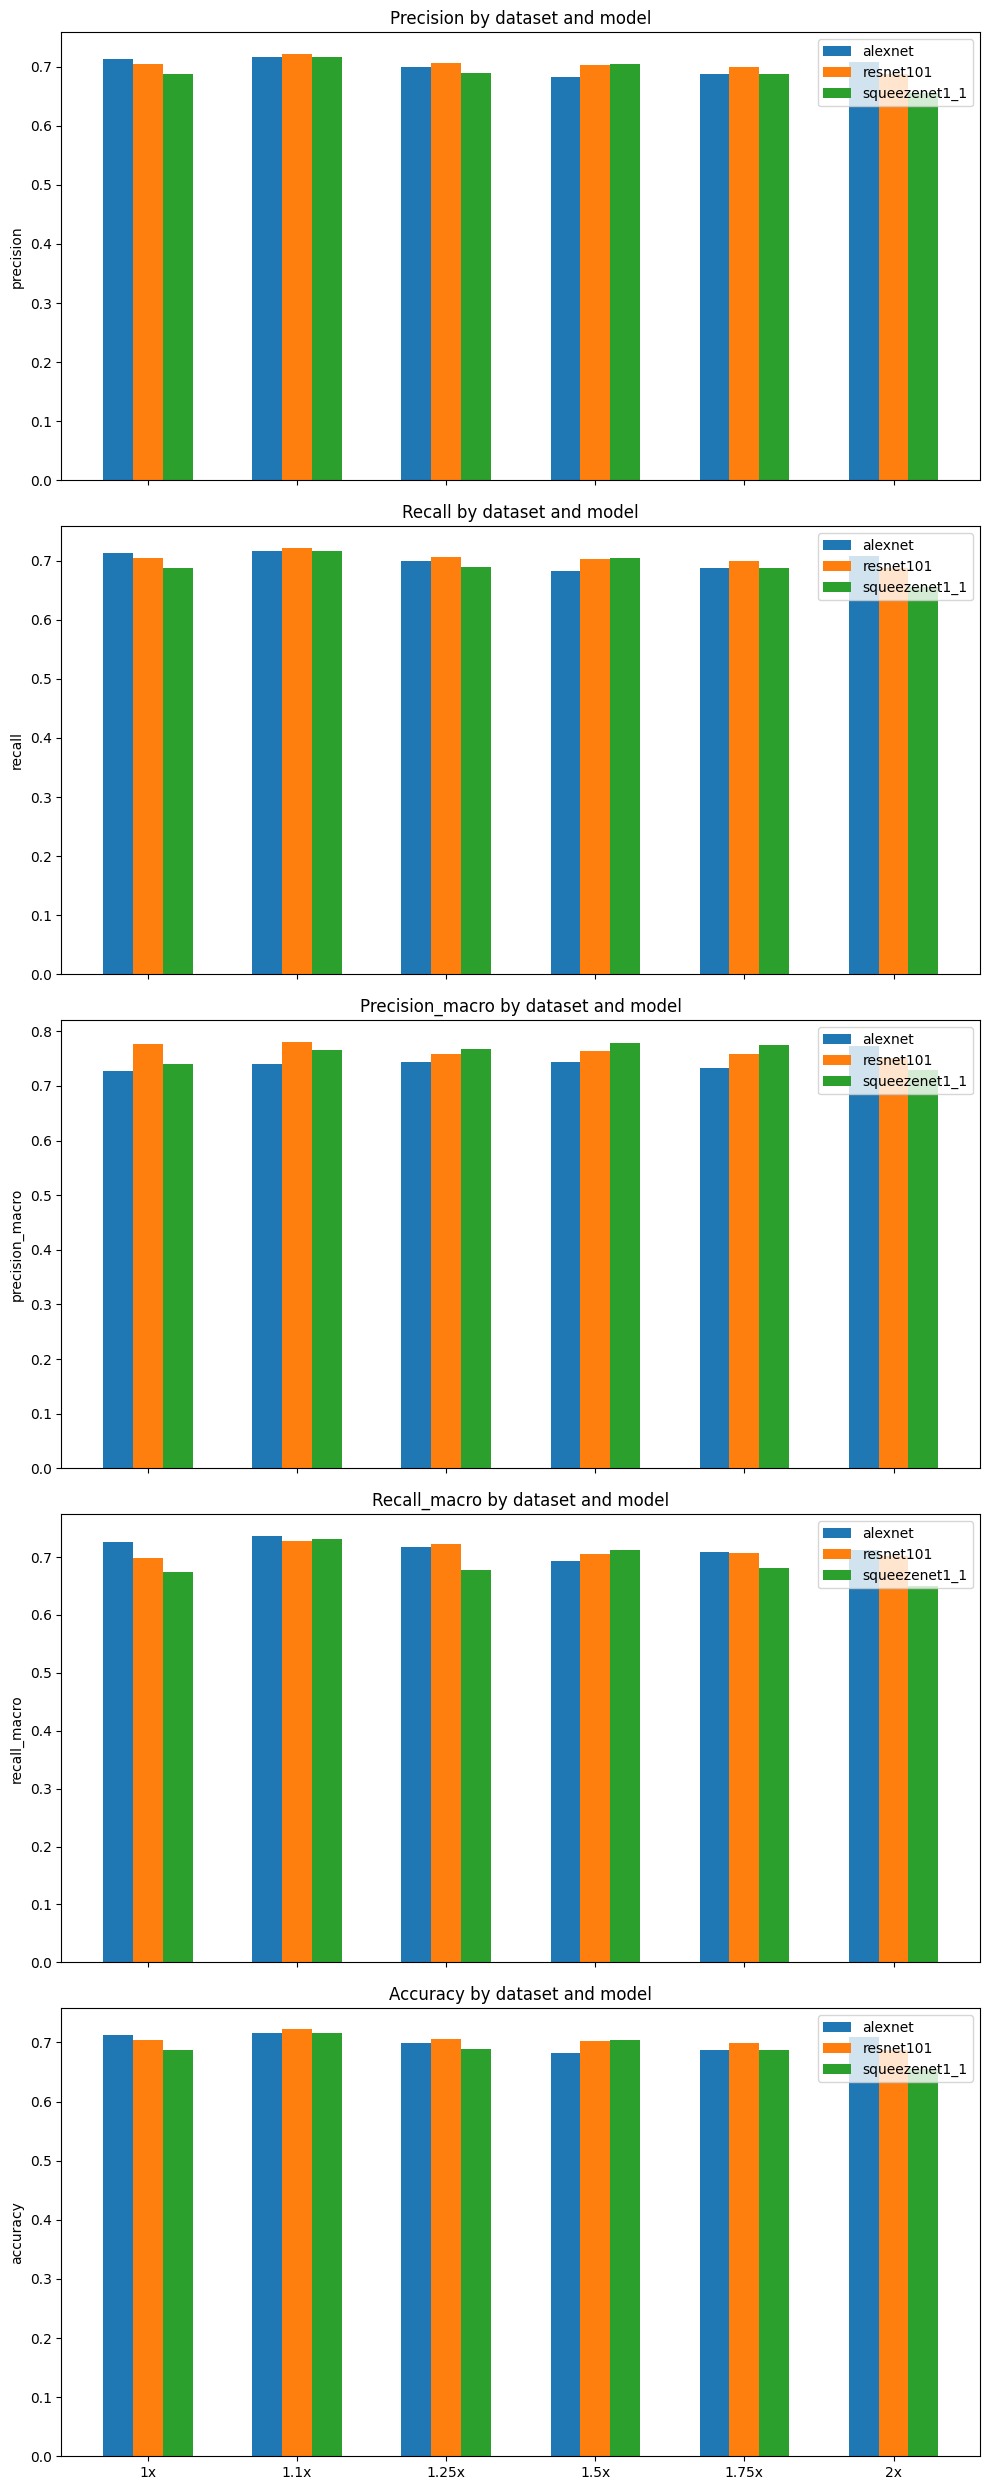

In [5]:
# Call the plot function with your results
plot_metrics(results)